# 第3章

## 機械学習モデル開発のワークフローと本章で扱う内容

なお、動作確認は以下の環境で行いました。

- Machine (AWS EC2 p2.xlargeインスタンス)
    - OS: Ubuntu 16.04
    - CPU: Intel(R) Xeon(R) CPU E5-2686 v4 @ 2.30GHz
    - RAM: 64GB 
    - GPU: NVIDIA Tesla K80
- Python
    - Python 3.7
    - PyTorch 1.3

## 文書分類ハンズオン

### 本章で扱う自然言語処理ツールの解説

#### Transformers

Transformersで用いることのできるモデルのリストはHugging Faceのホームページ (https://huggingface.co/models) にて公開されています。

-  `bert-base-japanese`:
-  `bert-base-japanese-whole-word-masking`
-  `bert-base-japanese-char`
-  `bert-base-japanese-char-whole-word-masking`

Transformersは、FaceBookが開発しているPyTorchおよび、GoogleのTensorFlowのバージョン2.0以降に対応しています。ここではPyTorchを用いることにします。

In [ ]:
# 環境によってインストールコマンドが異なります。https://pytorch.org/get-started/を参照してください。
# 2019年12月現在、NVIDIAのGPUを搭載したLinuxマシンにAnacondaでPyTorchをインストールするコマンドは以下の通りです。
!conda install pytorch torchvision cudatoolkit=10.1 -c pytorch
# LinuxでかつGPUがない場合は !conda install pytorch torchvision cpuonly -c pytorch

便利なtorchtext

In [ ]:
!conda install torchtext -c pytorch

In [15]:
!pip install transformers

`bert-base-japanese*` は形態素解析のライブラリとして内部でMeCabを用いているので、`mecab-python3` もインストールしておきましょう。

In [ ]:
!pip install mecab-python3

また、以降で補助的に利用するライブラリもインストールしてください。

In [122]:
!pip install pandas scikit-learn seaborn mojimoji

  Created wheel for mojimoji: filename=mojimoji-0.0.9-cp37-cp37m-linux_x86_64.whl size=116391 sha256=c849771a8fb83d62824d13e869c1491f75990b1459b63cc0b5106e40c61bf63c
  Stored in directory: /home/ubuntu/.cache/pip/wheels/67/f0/6e/03e5c5017afc8230e19abeacad57189138207fea2f5dd71880
Successfully built mojimoji


- pandas
- scikit-learn
- seaborn
- mojimoji

BERTを用いて日本語の文章を分類する手順はおおまかに書くと以下のようになります。

1. aaa
2. aaa



In [2]:
from transformers import BertJapaneseTokenizer

In [3]:
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')
tokenizer.tokenize('いつもプレゼンテーションの撮影に無音カメラアプリをご利用いただきありがとうございます。')

['いつも',
 'プレゼンテーション',
 'の',
 '撮影',
 'に',
 '無',
 '##音',
 'カメラ',
 '##アプリ',
 'を',
 'ご',
 '利用',
 'いただ',
 '##き',
 'ありがとう',
 'ござい',
 'ます',
 '。']

### データセットの準備
#### livedoor ニュースコーパス

今回は日本語における自然言語処理の試験用データセットとしてしばしば用いられる「livedoor ニュースコーパス」を用います。

livedoorニュースはもともと株式会社ライブドアが運営するニュースサイトでしたが、株式会社ライブドアが旧ハンゲームジャパン株式会社であるNHN Japan株式会社に買収され、現在はNHN Japanが社名変更したLINE株式会社により運営されています。livedoorニュースの記事の一部には「クリエイティブ・コモンズライセンス『表示 – 改変禁止』」が適用されており、営利目的を含めて再配布可能となっています。該当するニュース記事を2012年9月上旬に株式会社ロンウイットが収集し、HTMLタグの除去などクリーニングを施した状態で公開しているのが「livedoor ニュースコーパス」です。

livedoor ニュースコーパスは以下のリンクよりダウンロード可能です。

https://www.rondhuit.com/download.html#ldcc

オープンソースの全文検索システムApache Solrで扱いやすいようXML形式でニュースが格納されている `livedoor-news-data.tar.gz` と、シンプルに各々のニュースをテキストファイルとして扱っている `ldcc-20140209.tar.gz` が公開されています。

今回は後者の `ldcc-20140209.tar.gz` をダウンロードしてください。`tar xzvf ldcc-20140209.tar.gz` などにより解凍すると `text` という名前のディレクトリが出てきます。以下のPythonスクリプトを実行するとコーパスのダウンロードと圧縮ファイルの解凍が行われ、カレントディレクトリに `text` ディレクトリが作成されます。

In [4]:
import os
import urllib.request
import tarfile

# dataディレクトリの作成
#os.makedirs('data', exist_ok=True)

url = 'https://www.rondhuit.com/download/ldcc-20140209.tar.gz'
file_name = 'ldcc-20140209.tar.gz'

# dataディレクトリへのlivedoor ニュースコーパスのダウンロードと解凍
if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    # tar.gzファイルを読み込み
    with tarfile.open(file_name) as tar:
        tar.extractall()
    # tar.gzファイルを消去
    os.remove(file_name)

`text` ディレクトリの中身の構造は以下の通りです。

```
text
├── CHANGES.txt
├── README.txt
├── dokujo-tsushin
├── it-life-hack
├── kaden-channel
├── livedoor-homme
├── movie-enter
├── peachy
├── smax
├── sports-watch
└── topic-news
```

`dokujo-tsushin` から `topic-news` はディレクトリであり、それぞれにニュース記事のテキストが格納されています。

```
text
├── CHANGES.txt
├── README.txt
├── dokujo-tsushin
│   ├── LICENSE.txt
│   ├── dokujo-tsushin-4778030.txt
│   ├── dokujo-tsushin-4778031.txt
│   ├── dokujo-tsushin-4782522.txt
...（以下略）
```

ニュース提供元は以下の9つです。記事の本文だけを見て、その記事がどのカテゴリに属しているのか（独女通信のニュースなのか、ITライフハックのニュースなのか、など）を判別する文書分類モデルを作成するのが本章の目的です。

- 独女通信 (http://news.livedoor.com/category/vender/90/)
- ITライフハック (http://news.livedoor.com/category/vender/223/)
- 家電チャンネル (http://news.livedoor.com/category/vender/kadench/)
- livedoor HOMME (http://news.livedoor.com/category/vender/homme/)
- MOVIE ENTER (http://news.livedoor.com/category/vender/movie_enter/)
- Peachy (http://news.livedoor.com/category/vender/ldgirls/)
- エスマックス (http://news.livedoor.com/category/vender/smax/)
- Sports Watch (http://news.livedoor.com/category/vender/208/)
- トピックニュース (http://news.livedoor.com/category/vender/news/)

ちなみに、上記サービスのうちいくつかはドメインが変わっていたり終了しているので一部リンクが切れています。それぞれの記事ファイル（dokujo-tsushin-4778030.txtなど）は以下のフォーマットで構成されています。

- １行目: 記事のURL
- ２行目: 記事の日付
- ３行目: 記事のタイトル
- ４行目以降： 記事の本文

このままでは少し扱いづらいのでひとつのtsv (tab-separated values) にまとめます。

In [1]:
services = [
    'dokujo-tsushin',
    'it-life-hack',
    'kaden-channel',
    'livedoor-homme',
    'movie-enter',
    'peachy',
    'smax',
    'sports-watch',
    'topic-news'
]
index = ['url', 'datetime', 'title', 'body']

In [2]:
import os
import glob

import pandas as pd

# 空のPandasのDataFrameを準備
df = pd.DataFrame()

# 各サービスのディレクトリでループ
for service in services:
    print('===== processing {} ====='.format(service))
    # ニュース記事をすべて指定
    # パスの例は './text/dokujo-tsushin/dokujo-tsushin-4778030.txt'
    # LICENSE.txt は除外
    wild_card = os.path.join('text', service, service + '*.txt')
    file_paths = glob.glob(wild_card)
    # 各ニュース記事のファイルパスでループ
    for file_path in file_paths:
        # ファイルを開いて一行ずつ読み込む
        with open(file_path, 'r') as f:
            lines = f.readlines()
            # tsv のカラムを辞書型で用意
            series_dict = {'service': service}
            for num, line in enumerate(lines):
                # 改行を削除
                line = line.replace('\n', '')
                # 0, 1, 2行目はそれぞれURL, 日付, 記事タイトルに相当
                if num < len(index):
                    series_dict[index[num]] = line
                # 3行目以降は本文
                else:
                    series_dict['body'] += line
            # PandasのSeriesを作成し、DataFrameに追加していく
            s = pd.Series(series_dict)
            df = df.append(s, ignore_index=True)
print('done')         

===== processing dokujo-tsushin =====
===== processing it-life-hack =====
===== processing kaden-channel =====
===== processing livedoor-homme =====
===== processing movie-enter =====
===== processing peachy =====
===== processing smax =====
===== processing sports-watch =====
===== processing topic-news =====
done


作成した `DataFrame` の最初の5行と最後の5行だけ抜き出して表示してみましょう。
それぞれの行がひとつのニュース記事に対応していることより、0行から7366行の計7367個のニュース記事があることがわかります。

In [3]:
pd.concat([df.head(), df.tail()])

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900,dokujo-tsushin,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音,http://news.livedoor.com/article/detail/5934284/
1,多くの女性が悩む「お腹の張り」。ファッション誌をめくる度に「モデルさんは細くていいなあ…」...,2010-06-25T14:00:00+0900,dokujo-tsushin,まるで妊婦！？ モデルの7割が悩む「ポッコリお腹」,http://news.livedoor.com/article/detail/4848785/
2,実在した武士の家計簿を元に制作された映画「武士の家計簿」。家計簿をつけ収入収支を管理し、誠実...,2011-01-04T14:00:00+0900,dokujo-tsushin,つける？ つけない？ 独女の家計簿,http://news.livedoor.com/article/detail/5247353/
3,早いもので、もうすぐ季節は夏。今年は東日本を中心に、ビジネスシーンでのクールビズを例年以上に...,2011-06-22T12:30:00+0900,dokujo-tsushin,夏に多発！下着チラみせ独女はアリかナシか？,http://news.livedoor.com/article/detail/5653189/
4,女に必要なものは何か。一寸先は真っ暗闇の、生きるというより、生き抜かなくてはいけないこのご時...,2012-01-24T16:09:00+0900,dokujo-tsushin,東京23区女ひとり風呂 vol.04「文京区・銭湯後はこの一杯！」Presented by ...,http://news.livedoor.com/article/detail/6218046/
7362,今年のベストジーニスト一般選出部門に相葉雅紀、黒木メイサが選出された。その選出が“5年ぶりの...,2011-10-05T18:12:00+0900,topic-news,毎年話題になるベストジーニスト賞の偏り,http://news.livedoor.com/article/detail/5914835/
7363,25日、TBSは福島のドキュメンタリー映画を制作する18歳の米国人青年の活動を報じ、ネット掲...,2012-03-26T15:38:00+0900,topic-news,米国人制作の福島の映画「ニュー・ヒバクシャ」に戸惑いの声,http://news.livedoor.com/article/detail/6403803/
7364,28日発売の「週刊文春」（7月5日号）では、「原一億円恐喝事件で『中畑清DeNA監督が元暴力...,2012-06-28T18:20:00+0900,topic-news,中畑監督の“暴力団員仲介”報道、ネットでも疑問の声続々,http://news.livedoor.com/article/detail/6703537/
7365,4日、Web版「週刊現代」が掲載した記事「民主も自民もついでに財界もこうしてぶっ潰す 橋下徹...,2012-07-04T13:30:00+0900,topic-news,ミキハウスグループ社長が橋下大阪市長を公然批判。ネット上でも話題に,http://news.livedoor.com/article/detail/6723717/
7366,20日、日本の原子力基本法に「安全保障」条項が追加されたが、韓国では「日本が核武装を企んでい...,2012-06-21T20:32:00+0900,topic-news,原子力基本法の改正に、韓国から「日本の核武装を阻止すべき」「我々も核武装だ」の声,http://news.livedoor.com/article/detail/6681547/


In [4]:
df['service'].value_counts()

sports-watch      900
smax              870
it-life-hack      870
dokujo-tsushin    870
movie-enter       870
kaden-channel     864
peachy            842
topic-news        770
livedoor-homme    511
Name: service, dtype: int64

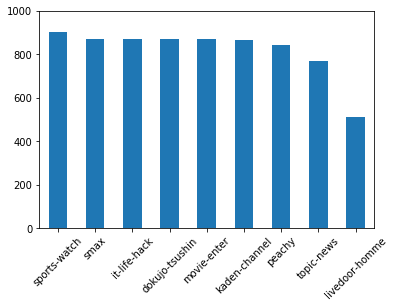

In [5]:
(df['service'].value_counts()).plot(kind='bar', rot=45, ylim=(0, 1000))

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['service'] = le.fit_transform(df.service.values)
df.head()

,body,datetime,service,title,url
0,「しっかりメイクをしている顔よりも、スッピンのほうがいい」と言う男性は少なくない。しかしメイ...,2011-10-13T15:28:00+0900,0,「スッピンのほうがいい」って本当？——言葉の裏に隠された男の本音,http://news.livedoor.com/article/detail/5934284/
1,多くの女性が悩む「お腹の張り」。ファッション誌をめくる度に「モデルさんは細くていいなあ…」...,2010-06-25T14:00:00+0900,0,まるで妊婦！？ モデルの7割が悩む「ポッコリお腹」,http://news.livedoor.com/article/detail/4848785/
2,実在した武士の家計簿を元に制作された映画「武士の家計簿」。家計簿をつけ収入収支を管理し、誠実...,2011-01-04T14:00:00+0900,0,つける？ つけない？ 独女の家計簿,http://news.livedoor.com/article/detail/5247353/
3,早いもので、もうすぐ季節は夏。今年は東日本を中心に、ビジネスシーンでのクールビズを例年以上に...,2011-06-22T12:30:00+0900,0,夏に多発！下着チラみせ独女はアリかナシか？,http://news.livedoor.com/article/detail/5653189/
4,女に必要なものは何か。一寸先は真っ暗闇の、生きるというより、生き抜かなくてはいけないこのご時...,2012-01-24T16:09:00+0900,0,東京23区女ひとり風呂 vol.04「文京区・銭湯後はこの一杯！」Presented by ...,http://news.livedoor.com/article/detail/6218046/


In [7]:
from sklearn.model_selection import train_test_split
df = df[['body', 'service']]
train_df, val_test_df = train_test_split(df, test_size=0.2)
val_df, test_df = train_test_split(val_test_df, test_size=0.5)

`DataFrame` をCSV (Comma-Separated Value) やTSV (Tab-Separated Value) で保存するには `pandas.DataFrame.to_csv` メソッドを呼び出します。ひとつ目の引数 `path_or_buf` には保存先のファイルパス（もしくはファイルオブジェクト）を指定し、ふたつ目の引数 `sep` には列のセパレーターを指定します。デフォルトでは `sep=','` となっており、セパレーターはカンマ、つまり `DataFrame` はCSVで保存されます。自然言語処理を行う場合、データ内にカンマが含まれていることがあるのでしばしばセパレーターとしてはタブ (`\t`) が用いられます。ここでは `DataFrame` をTSVの形式で保存します。

In [8]:
train_df.to_csv('train.tsv', sep='\t', index=False)
val_df.to_csv('val.tsv', sep='\t', index=False)
test_df.to_csv('test.tsv', sep='\t', index=False)

#### ラベリング

### 前処理



#### 形態素解析
#### ストップワード除去

### 文書分類モデル





In [99]:
"""
import pandas as pd
df = pd.read_csv('news.tsv', sep='\t', index_col=0)
df = df[['body', 'service']]
df.head()
"""

"\nimport pandas as pd\ndf = pd.read_csv('news.tsv', sep='\t', index_col=0)\ndf = df[['body', 'service']]\ndf.head()\n"

In [103]:
"""
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['service'] = le.fit_transform(df.service.values)
df.head()
"""

"\nfrom sklearn.preprocessing import LabelEncoder\nle = LabelEncoder()\ndf['service'] = le.fit_transform(df.service.values)\ndf.head()\n"

In [104]:
#train_df.head()

,body,service
1536,先週前半は、嵐の前の静けさといった感じで、かなり平穏でした。それもあってニュースのネタ探しに...,1
6175,23日、千葉県総合スポーツセンター陸上競技場では、国際千葉駅伝が行われた。レースは、ケニアが...,7
5130,ゼロから始めるスマートフォン ZTEは19日（現地時間）、現在シンガポールで開催されている展...,6
1123,ドコモは2012年3月5日 、「ドコモwebメール」を2012年8月27日午前11時をもって...,1
3450,現在、全米で大ヒット継続中で、2年連続“最も好きな犯罪ドラマ”にも選ばれている人気海外ドラ...,4


In [92]:
#val_df.head()

,body,service
2513,省エネ効果があり、従来の蛍光灯や電球と違って長期間使用が可能で、しかも明るいLEDライト。今...,2
3374,ＳＦ小説の巨匠ロバート・Ａ・ハインラインの傑作『宇宙の戦士』を映画化し、巨大昆虫と戦う兵士...,4
6048,昨年12月、大阪府立体育会館で開催された、ボクシング・WBA世界ダブルタイトルマッチにおいて...,7
6894,20日、ハロープロジェクトに所属するアイドルグループ「スマイレージ」のスタッフが管理するツイ...,8
1485,先日ひと騒動あった不審なAndroidアプリの件、「ヘンなアプリに要注意！ データぶっこ抜き...,1


In [2]:
from transformers import BertForSequenceClassification
net = BertForSequenceClassification.from_pretrained('bert-base-japanese-whole-word-masking', num_labels=9)
net.to('cuda')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

このニューラルネットワークの構造をnetron (https://github.com/lutzroeder/netron) というツールを用いて可視化すると次のようになります。
<img src="../figures/bert_classifier_netron.png" alt="bert_classifier_netron" width="150">
BERTモデルの構造が `BertModel` に押し込められているため、やけにシンプルに見えますが、ここではあまり深く考えないようにします。

PyTorchを用いてディープラーニングを実装する際には

In [3]:
from torchtext.data import Field
from transformers import BertJapaneseTokenizer
tokenizer = BertJapaneseTokenizer.from_pretrained('bert-base-japanese-whole-word-masking')

import re
import mojimoji

def tokenizer_with_preprocessing(text):
        # 半角、全角の変換
        text = mojimoji.han_to_zen(text)
        # 改行、半角スペース、全角スペースを削除
        text = re.sub('\r', '', text)
        text = re.sub('\n', '', text)
        text = re.sub('　', '', text)
        text = re.sub(' ', '', text)
        # 数字文字の一律「0」化
        text = re.sub(r'[0-9 ０-９]', '0', text)  # 数字
        return tokenizer.tokenize(text)
    
TEXT = Field(
    sequential=True,  
    tokenize=tokenizer_with_preprocessing, 
    use_vocab=True,
    lower=False,
    include_lengths=True,
    batch_first=True,
    fix_length=512,
    init_token='[CLS]',
    eos_token='[SEP]',
    pad_token='[PAD]',
    unk_token='[UNK]'
)
LABEL = Field(sequential=False, use_vocab=False)

In [4]:
from torchtext.data import TabularDataset
train, val, test = TabularDataset.splits(path='.', train='train.tsv', validation='val.tsv', test='test.tsv', format='tsv', fields=[('body', TEXT), ('service', LABEL)])

In [5]:
TEXT.build_vocab(train, min_freq=1)
TEXT.vocab.stoi = tokenizer.vocab

In [17]:
import torch
from torchtext.data import Iterator
batch_size = 8
train_iter, val_iter, test_iter = Iterator.splits((train, val, test), batch_size=batch_size, device='cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
iterator_dict = {'train': train_iter, 'val': val_iter, 'test': test_iter}

In [19]:
"""
net.to('cuda')
batch = next(iter(train_iter))
inputs = batch.body[0]
labels = batch.service
loss, logit = net(inputs, labels=labels)
"""

"\nnet.to('cuda')\nbatch = next(iter(train_iter))\ninputs = batch.body[0]\nlabels = batch.service\nloss, logit = net(inputs, labels=labels)\n"

In [20]:
for name, param in net.named_parameters():
    param.requires_grad = False

In [21]:
for name, param in net.bert.encoder.layer[-1].named_parameters():
    param.requires_grad = True

In [22]:
for name, param in net.classifier.named_parameters():
    param.requires_grad = True

In [23]:
optimizer = torch.optim.Adam([
    {'params': net.bert.encoder.layer[-1].parameters(), 'lr': 5e-5},
    {'params': net.classifier.parameters(), 'lr': 5e-5}
], betas=(0.9, 0.999))

In [24]:
criterion = torch.nn.CrossEntropyLoss()

In [43]:
def train_model(net, iterator_dict, criterion, optimizer, num_epochs):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.
            epoch_corrects = 0
            iteration = 1
            
            for batch in iterator_dict[phase]:
                inputs = batch.body[0]
                labels = batch.service
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    loss, logit = net(input_ids=inputs, labels=labels)
                    #print(loss, logit)
                    _, preds = torch.max(logit, 1)
                    #predictions.append(preds.cpu().numpy())
                    #ground_truths.append(labels.data.cpu().numpy())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        if (iteration % 10 == 0):
                            acc = (torch.sum(preds == labels.data)).double() / batch_size
                            print('iteration {} || Loss: {:.4f} || acc {}'.format(
                                iteration, loss.item(), acc.item()))
                    iteration += 1
                    
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)
        epoch_loss = epoch_loss / len(iterator_dict[phase].dataset)
        epoch_acc = epoch_corrects.double() / len(iterator_dict[phase].dataset)
        
        print('Epoch {}/{} | {} | Loss: {:.4f} Acc: {:.4f}'.format(
            epoch+1, num_epochs, phase, epoch_loss, epoch_acc))
    return net

In [44]:
num_epochs = 2
net_trained = train_model(net, iterator_dict, criterion, optimizer, num_epochs)

iteration 10 || Loss: 1.5891 || acc 0.625
iteration 20 || Loss: 1.5974 || acc 0.75
iteration 30 || Loss: 1.2715 || acc 0.625
iteration 40 || Loss: 1.5708 || acc 0.5
iteration 50 || Loss: 0.8519 || acc 0.875
iteration 60 || Loss: 1.2821 || acc 0.375
iteration 70 || Loss: 0.6059 || acc 1.0
iteration 80 || Loss: 0.5998 || acc 1.0
iteration 90 || Loss: 0.6772 || acc 0.75
iteration 100 || Loss: 1.0835 || acc 0.625
iteration 110 || Loss: 0.6970 || acc 0.75
iteration 120 || Loss: 1.1107 || acc 0.625
iteration 130 || Loss: 0.6839 || acc 0.75
iteration 140 || Loss: 0.8002 || acc 0.75
iteration 150 || Loss: 0.5608 || acc 0.75
iteration 160 || Loss: 1.4367 || acc 0.5
iteration 170 || Loss: 0.6620 || acc 0.75
iteration 180 || Loss: 0.1703 || acc 1.0
iteration 190 || Loss: 0.5071 || acc 0.875
iteration 200 || Loss: 0.8674 || acc 0.625
iteration 210 || Loss: 0.5108 || acc 0.875
iteration 220 || Loss: 0.5729 || acc 0.875
iteration 230 || Loss: 0.4816 || acc 0.875
iteration 240 || Loss: 0.6490 || acc 

ValueError: invalid literal for int() with base 10: 'service'

### 評価と比較

### モデルのデプロイ

## まとめ